### Data import and overview

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("../data/raw/WA_Fn-UseC_-Telco-Customer-Churn.csv")

print(df.shape)
print(df["Churn"].value_counts(normalize=True)) # Churn check

pd.set_option('display.max_columns', None)
df.head()

(7043, 21)
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


### Data inspection (types, missing values, duplicates, unique values)

In [19]:
print(df.info())  # Data types and non-null counts
print("\nMissing values:\n", df.isnull().sum())  # Should be zero, but confirm
print("\nDuplicates:", df.duplicated().sum())  # Expect zero

print("\nUnique values inspection for every column:")
# Check unique values for categorical columns (spot inconsistencies)
categoricals = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
                'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
                'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'Churn']
for col in categoricals:
    print("\n", df[col].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


### Fixing TotalCharges type

In [20]:
# Fix TotalCharges (it's an object due to spaces; convert to float)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
print(df[['TotalCharges']].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 1 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TotalCharges  7032 non-null   float64
dtypes: float64(1)
memory usage: 55.2 KB
None


### TotalCharges missing values inspection

In [21]:
# View the rows where TotalCharges is NaN
display(df[df['TotalCharges'].isnull()])

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


In every entry where the TotalCharge is missing, the tenure is 0.
This tells us that the customer is new and that they haven't even been charged for their first month.
Therefore, the best course of action here is to fill the missing values with 0 (because the customers haven't been charged anything yet)

### Filling the missing TotalCharges values

In [22]:
# Fill the 11 missing values with 0
df['TotalCharges'] = df['TotalCharges'].fillna(0)

# Verify the count is now 0
print("Missing values in TotalCharges:", df['TotalCharges'].isnull().sum())

Missing values in TotalCharges: 0


### Converting the SeniorCitizen column to text for consistency

In [24]:
# Map 0 to 'No' and 1 to 'Yes'
df['SeniorCitizen'] = df['SeniorCitizen'].map({0: 'No', 1: 'Yes'})

# Verify the change
print("SeniorCitizen unique values after conversion:")
print(df['SeniorCitizen'].value_counts())

SeniorCitizen unique values after conversion:
SeniorCitizen
No     5901
Yes    1142
Name: count, dtype: int64


### Numerical data inspection (distributions, skewness, outliers)

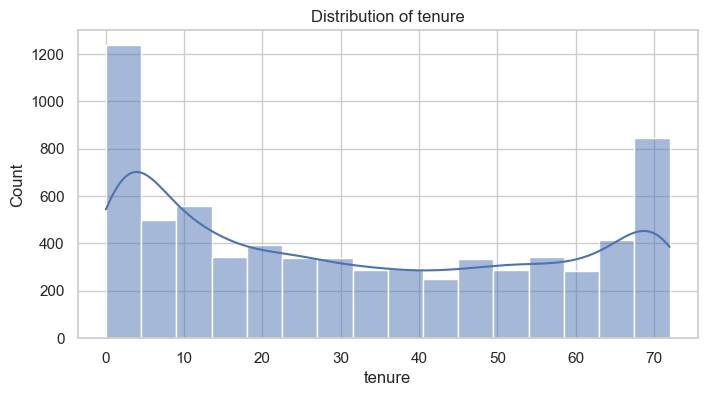

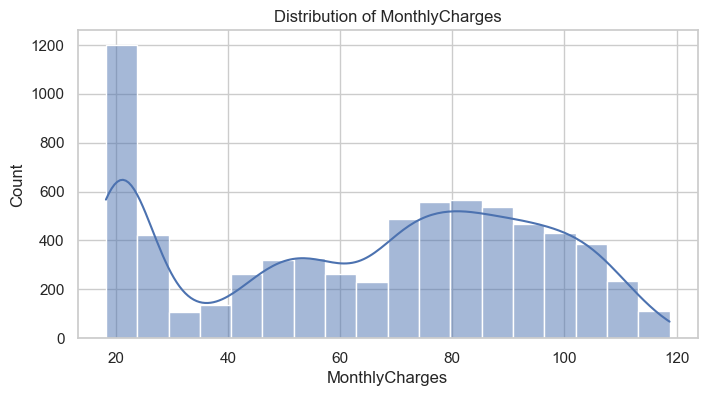

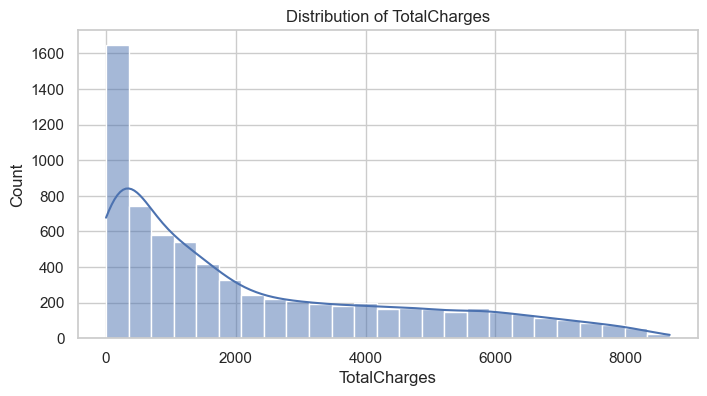

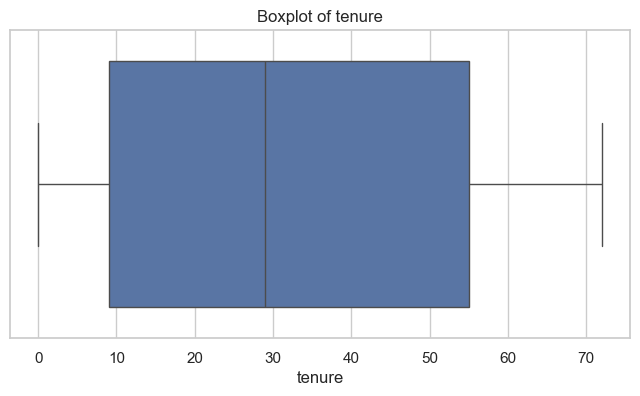

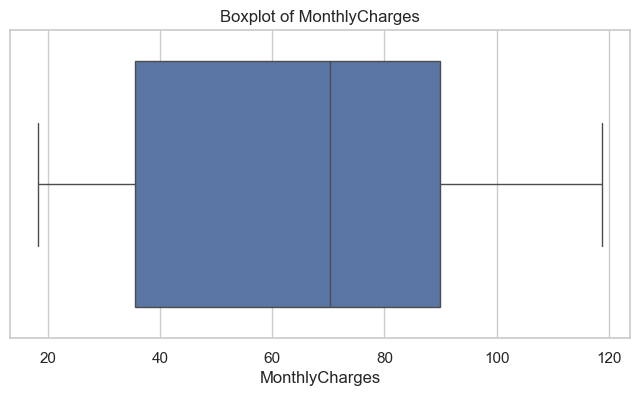

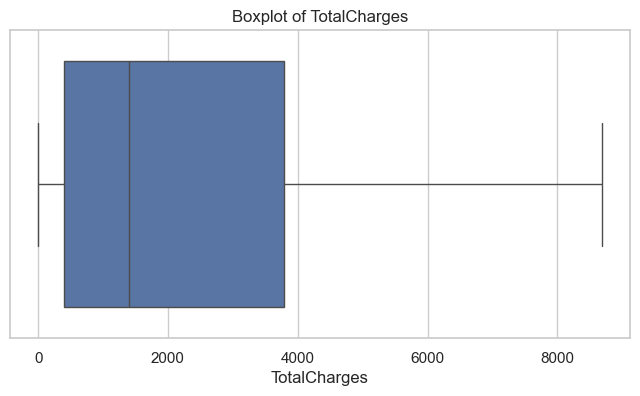

In [25]:
# Set style for better visuals
sns.set_theme(style="whitegrid")

# Numeric distributions
numerics = ['tenure', 'MonthlyCharges', 'TotalCharges']
for col in numerics:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution of {col}")
    plt.show()

# Boxplots for outliers
for col in numerics:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

Insights:
- Tenure has a u-shape and it shows that there are two main groups: new customers and very old customers. The number of customers significantly drops the middle which suggests that there is a high risk of churn with new customers. Furthermore, it suggests that the customers who survive the period in the middle stay customers for a very long time. 
- Monthly charges show clusters around differently priced plans.
- Total charges are right-skewed which shows that there is a lot of customers that pay smaller amounts of money. The more money is paid the less customers there is.